In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
pip install node2vec

In [54]:

%matplotlib inline

import warnings
from text_unidecode import unidecode
from collections import deque
warnings.filterwarnings('ignore')


import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from node2vec import Node2Vec

sns.set_style('whitegrid')

In [55]:
# Load data 
data = pd.read_csv('/content/drive/My Drive/FIFA17_Graph_Embeddings/FullData.csv', usecols=['Name', 'Club', 'Club_Position', 'Rating'])

# Lowercase columns for convenience
data.columns = list(map(str.lower, data.columns))

# Reformat strings: lowercase, ' ' -> '_' and é, ô etc. -> e, o
reformat_string = lambda x: unidecode(str.lower(x).replace(' ', '_'))
    
data['name'] = data['name'].apply(reformat_string)
data['club'] = data['club'].apply(reformat_string)

# Lowercase position
data['club_position'] = data['club_position'].str.lower()

# Ignore substitutes and reserves 
data = data[(data['club_position'] != 'sub') & (data['club_position'] != 'res')]

# Fix lcm rcm -> cm cm
fix_positions = {'rcm' : 'cm', 'lcm': 'cm', 'rcb': 'cb', 'lcb': 'cb', 'ldm': 'cdm', 'rdm': 'cdm'}
data['club_position'] = data['club_position'].apply(lambda x: fix_positions.get(x, x))

# For example sake we will keep only 7 clubs
clubs = {'real_madrid', 'manchester_utd', 
         'manchester_city', 'chelsea', 'juventus', 
         'fc_bayern', 'napoli'}

data = data[data['club'].isin(clubs)]


# Verify we have 11 player for each team
assert all(n_players == 11 for n_players in data.groupby('club')['name'].nunique())

data

,name,club,club_position,rating
0,cristiano_ronaldo,real_madrid,lw,94
4,manuel_neuer,fc_bayern,gk,92
5,de_gea,manchester_utd,gk,90
6,robert_lewandowski,fc_bayern,st,90
7,gareth_bale,real_madrid,rw,90
...,...,...,...,...
615,marcos_alonso,chelsea,lwb,79
687,gael_clichy,manchester_city,lb,79
850,victor_moses,chelsea,rwb,78
892,willy_caballero,manchester_city,gk,78


In [99]:
FORMATIONS = {'4-3-3_4': {'gk': ['cb_1', 'cb_2'],                           # Real madrid
                          'lb': ['lw', 'cb_1', 'cm_1'],
                          'cb_1': ['lb', 'cb_2', 'gk'],
                          'cb_2': ['rb', 'cb_1', 'gk'],
                          'rb': ['rw', 'cb_2', 'cm_2'],
                          'cm_1': ['cam', 'lw', 'cb_1', 'lb'],
                          'cm_2': ['cam', 'rw', 'cb_2', 'rb'],
                          'cam': ['cm_1', 'cm_2', 'st'],
                          'lw': ['cm_1', 'lb', 'st'],
                          'rw': ['cm_2', 'rb', 'st'],
                          'st': ['cam', 'lw', 'rw']},
              '5-2-2-1': {'gk': ['cb_1', 'cb_2', 'cb_3'],                   # Chelsea
                          'cb_1': ['gk', 'cb_2', 'lwb'],
                          'cb_2': ['gk', 'cb_1', 'cb_3', 'cm_1', 'cb_2'],
                          'cb_3': ['gk', 'cb_2', 'rwb'],
                          'lwb': ['cb_1', 'cm_1', 'lw'],
                          'cm_1': ['lwb', 'cb_2', 'cm_2', 'lw', 'st'],
                          'cm_2': ['rwb', 'cb_2', 'cm_1', 'rw', 'st'],
                          'rwb': ['cb_3', 'cm_2', 'rw'],
                          'lw': ['lwb', 'cm_1', 'st'],
                          'st': ['lw', 'cm_1', 'cm_2', 'rw'],
                          'rw': ['st', 'rwb', 'cm_2']},
              '4-3-3_2': {'gk': ['cb_1', 'cb_2'],                           # Man UTD / CITY
                          'lb': ['cb_1', 'cm_1'],
                          'cb_1': ['lb', 'cb_2', 'gk', 'cdm_1'],
                          'cb_2': ['rb', 'cb_1', 'gk', 'cdm_1'],
                          'rb': ['cb_2', 'cm_2'],
                          'cm_1': ['cdm_1', 'lw', 'lb', 'st'],
                          'cm_2': ['cdm_1', 'rw', 'st', 'rb'],
                          'cdm_1': ['cm_1', 'cm_2', 'cb_1', 'cb_2'],
                          'lw': ['cm_1', 'st'],
                          'rw': ['cm_2', 'st'],
                          'st': ['cm_1', 'cm_2', 'lw', 'rw']},              # Juventus, Bayern
              '4-2-3-1_2': {'gk': ['cb_1', 'cb_2'],
                            'lb': ['lm', 'cdm_1', 'cb_1'],
                            'cb_1': ['lb', 'cdm_1', 'gk', 'cb_2'],
                            'cb_2': ['rb', 'cdm_2', 'gk', 'cb_1'],
                            'rb': ['cb_2', 'rm', 'cdm_2'],
                            'lm': ['lb', 'cdm_1', 'st', 'cam'],
                            'rm': ['rb', 'cdm_2', 'st', 'cam'],
                            'cdm_1': ['lm', 'cb_1', 'rb', 'cam'],
                            'cdm_2': ['rm', 'cb_2', 'lb', 'cam'],
                            'cam': ['cdm_1', 'cdm_2', 'rm', 'lm', 'st'],
                            'st': ['lm', 'rm', 'cam']},
              '4-3-3': {'gk': ['cb_1', 'cb_2'],                             # napoli
                        'lb': ['cb_1', 'cm_1'],
                        'cb_1': ['lb', 'cb_2', 'gk', 'cm_2'],
                        'cb_2': ['rb', 'cb_1', 'gk', 'cm_2'],
                        'rb': ['cb_2', 'cm_3'],
                        'cm_1': ['cm_2', 'lw', 'lb'],
                        'cm_3': ['cm_2', 'rw', 'rb'],
                        'cm_2': ['cm_1', 'cm_3', 'st', 'cb_1', 'cb_2'],
                        'lw': ['cm_1', 'st'],
                        'rw': ['cm_3', 'st'],
                        'st': ['cm_2', 'lw', 'rw']}}

In [27]:
formation='4-3-3'
club_formation = FORMATIONS[formation]
club_formation

q=deque(club_formation)
while q:
  a=q.pop()
  print(a)

st
rw
lw
cm_2
cm_3
cm_1
rb
cb_2
cb_1
lb
gk


In [120]:
add_club_suffix = lambda x, c: x + '_{}'.format(c)

graph = nx.Graph()
formatted_positions = set()

def club2graph(club_name, formation, graph):

  import random
  #club_name='real_madrid'
  club_data = data[data['club'] == club_name]
  club_data
  available_players = set(zip(club_data['name'], club_data['club_position']))
  available_players
  #formation='4-3-3_4'
  club_formation = FORMATIONS[formation]
  club_formation

  q=deque(club_formation)
  roster = dict()
  name=[]
  position=[]
  while q:
    p=q.pop()
    name,pos = [(name, p) for name, p in available_players if p.startswith(p)][0]
    #print(name,pos)
    roster[name] = pos
    available_players.remove((name, pos.split('_')[0]))  

  #print(roster.items()) 
  value1=[]
  for key,value in roster.items():
    if value=='cb':
      #print('yes')
      value=random.choice(['cb_1','cb_2'])
      d1={key:value}
      roster.update(d1)
    if value=='cm':
      #print('yes')
      value=random.choice(['cm_1','cm_2'])
      d1={key:value}
      roster.update(d1)
    if value=='cdm':
      #print('yes')
      value=random.choice(['cdm_1'])
      d1={key:value}
      roster.update(d1)
  #print(roster.items())
  for k,v in roster.items():
    value1.append(v)
  #print(value1)
  reverse_roster = {v: k for k, v in roster.items()}
  #print(reverse_roster.items())



  for name, position in roster.items():
    # Connect to team name
    
    graph.add_edge(name, club_name)
    # Inter team connections
    for teammate_position in club_formation[position]:
      # Connect positions
      graph.add_edge(add_club_suffix(position, club_name),
                            add_club_suffix(teammate_position, club_name))
              
      # Connect player to teammate positions
      graph.add_edge(name,
                    add_club_suffix(teammate_position, club_name))
              
      # Connect player to teammates
      #print(teammate_position)
      #print(reverse_roster[teammate_position])
      if teammate_position not in (value1):

        graph.add_edge(name, 'cristiano_ronaldo')
      else:
        graph.add_edge(name, reverse_roster[teammate_position])
              
      # Save for later trimming
      formatted_positions.add(add_club_suffix(position, club_name))
      formatted_positions.add(add_club_suffix(teammate_position, club_name)) 
  return graph    
          

In [57]:
# add_club_suffix = lambda x, c: x + '_{}'.format(c)

# graph = nx.Graph()
# formatted_positions = set()

# def club2graph(club_name, formation, graph):
#     club_data = data[data['club'] == club_name]
    
#     club_formation = FORMATIONS[formation]
    
#     club_positions = dict()
    
#     # Assign positions to players
#     available_positions = deque(club_formation)
#     available_players = set(zip(club_data['name'], club_data['club_position']))
    
#     roster = dict()  # Here we will store the assigned players and positions
    
#     while available_positions:
#         position = available_positions.pop()
#         name, pos = [(name, p) for name, p in available_players if position.startswith(p)][0]       
        
#         roster[name] = pos
        
#         available_players.remove((name, pos.split('_')[0]))
        
#     reverse_roster = {v: k for k, v in roster.items()}
        
#     # Build the graph
#     for name, position in roster.items():
#         # Connect to team name
#         graph.add_edge(name, club_name)
        
#         # Inter team connections
#         for teammate_position in club_formation[position]:
#             # Connect positions
#             graph.add_edge(add_club_suffix(position, club_name),
#                            add_club_suffix(teammate_position, club_name))
            
#             # Connect player to teammate positions
#             graph.add_edge(name,
#                            add_club_suffix(teammate_position, club_name))
            
#             # Connect player to teammates
#             graph.add_edge(name, reverse_roster[teammate_position])
            
#             # Save for later trimming
#             formatted_positions.add(add_club_suffix(position, club_name))
#             formatted_positions.add(add_club_suffix(teammate_position, club_name))
            
#     return graph

In [121]:
teams = [('real_madrid', '4-3-3_4'), 
         ('chelsea', '5-2-2-1'),
         ('manchester_utd', '4-3-3_2'),
         ('manchester_city', '4-3-3_2'),
         ('juventus', '4-2-3-1_2'),
         ('fc_bayern', '4-2-3-1_2'),
         ('napoli', '4-3-3')]

In [122]:
#graph = club2graph('real_madrid', '4-3-3_4', graph)

for team, formation in teams:
    graph = club2graph(team, formation, graph)

In [123]:
node2vec = Node2Vec(graph, dimensions=20, walk_length=16, num_walks=100, workers=2)

Computing transition probabilities: 100%|██████████| 161/161 [00:00<00:00, 1982.16it/s]


In [124]:
fix_formatted_positions = lambda x: x.split('_')[0] if x in formatted_positions else x
reformatted_walks = [list(map(fix_formatted_positions, walk)) for walk in node2vec.walks]
node2vec.walks = reformatted_walks

In [125]:
model = node2vec.fit(window=10, min_count=1)

In [126]:
for node, _ in model.most_similar('rw'):
    # Show only players
    if len(node) > 3:
        print(node)

raheem_sterling
n'golo_kante
pedro
gareth_bale
carvajal
kevin_de_bruyne
sergio_aguero


In [127]:
for node, _ in model.most_similar('gk'):
    # Show only players
    if len(node) > 3:
        print(node)

manuel_neuer
willy_caballero
azpilicueta
mats_hummels
javi_martinez
nicolas_otamendi
john_stones
kalidou_koulibaly


In [128]:
for node, _ in model.most_similar('real_madrid'):
    print(node)

keylor_navas
sergio_ramos
james_rodriguez
pepe
toni_kroos
luka_modric
marcelo
karim_benzema
carvajal
gareth_bale


In [129]:
for node, _ in model.most_similar('paulo_dybala'):
    print(node)

gonzalo_higuain
mario_mandzukic
miralem_pjanic
sami_khedira
juan_cuadrado
alex_sandro
juventus
stephan_lichtsteiner
rm
leonardo_bonucci


In [134]:
print(model.wv.vocab)

{'rb': <gensim.models.keyedvectors.Vocab object at 0x7f74e76106d8>, 'kevin_de_bruyne': <gensim.models.keyedvectors.Vocab object at 0x7f74ea5a7390>, 'yaya_toure': <gensim.models.keyedvectors.Vocab object at 0x7f74ea5a73c8>, 'cm': <gensim.models.keyedvectors.Vocab object at 0x7f74ea5a7518>, 'cdm': <gensim.models.keyedvectors.Vocab object at 0x7f74ea5a7550>, 'david_silva': <gensim.models.keyedvectors.Vocab object at 0x7f74ea5a7588>, 'leroy_sane': <gensim.models.keyedvectors.Vocab object at 0x7f74ea5a75c0>, 'st': <gensim.models.keyedvectors.Vocab object at 0x7f74ea5a75f8>, 'raheem_sterling': <gensim.models.keyedvectors.Vocab object at 0x7f74ea5a7630>, 'lw': <gensim.models.keyedvectors.Vocab object at 0x7f74ea5a7668>, 'sergio_aguero': <gensim.models.keyedvectors.Vocab object at 0x7f74ea5a76a0>, 'manchester_city': <gensim.models.keyedvectors.Vocab object at 0x7f74ea5a76d8>, 'thomas_muller': <gensim.models.keyedvectors.Vocab object at 0x7f74ea5a7710>, 'arjen_robben': <gensim.models.keyedvecto

In [130]:
player_nodes = [x for x in model.wv.vocab if len(x) > 3 and x not in clubs]
embeddings = np.array([model.wv[x] for x in player_nodes])

In [131]:
tsne = TSNE(n_components=2, random_state=7, perplexity=15)
embeddings_2d = tsne.fit_transform(embeddings)

In [132]:
# Assign colors to players
team_colors = {
    'real_madrid': 'lightblue',
    'chelsea': 'b',
    'manchester_utd': 'r',
    'manchester_city': 'teal',
    'juventus': 'gainsboro',
    'napoli': 'deepskyblue',
    'fc_bayern': 'tomato' 

}

data['color'] = data['club'].apply(lambda x: team_colors[x])
player_colors = dict(zip(data['name'], data['color']))
colors = [player_colors[x] for x in player_nodes]

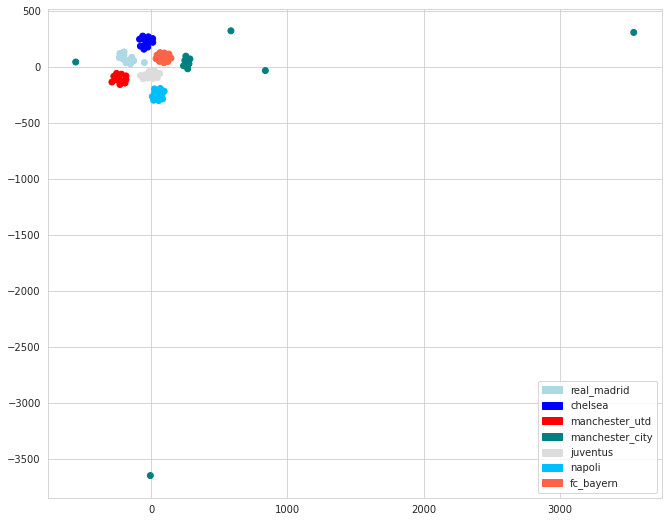

In [133]:
figure = plt.figure(figsize=(11, 9))

ax = figure.add_subplot(111)

ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors)

# Create team patches for legend
team_patches = [mpatches.Patch(color=color, label=team) for team, color in team_colors.items()]
ax.legend(handles=team_patches);